In [201]:
# RQA -- in between - raw quality assessment (amplitude * power frequency ratio * alpha band psd ratio)
# Extract file ---> collective data ---> Bad channel removal ----- Not needed [sampling rate correction (500Hz)] -----
# filtering (butterworth bandpass - tune coefficient)  ----- rereferencing ----- epoching ----- ERP ----- baseline removal ---- 

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import fftpack,  signal
import time
import mne
import matplotlib
from collections import UserDict


## Reading the eeg data

In [260]:
channel_str='Channel 1:P8\
	Channel 2:T8\
	Channel 3:CP6\
	Channel 4:FC6\
	Channel 5:F8\
	Channel 6:F4\
	Channel 7:C4\
	Channel 8:P4\
	Channel 9:AF4\
	Channel 10:Fp2\
	Channel 11:Fp1\
	Channel 12:AF3\
	Channel 13:Fz\
	Channel 14:FC2\
	Channel 15:Cz\
	Channel 16:CP2\
	Channel 17:PO3\
	Channel 18:O1\
	Channel 19:Oz\
	Channel 20:O2\
	Channel 21:PO4\
	Channel 22:Pz\
	Channel 23:CP1\
	Channel 24:FC1\
	Channel 25:P3\
	Channel 26:C3\
	Channel 27:F3\
	Channel 28:F7\
	Channel 29:FC5\
	Channel 30:CP5\
	Channel 31:T7\
	Channel 32:P7'

string_channels = channel_str.replace('\t', ':').split(':')
channel_names = [string_channels[i] for i in range(len(string_channels)) if i % 2 != 0]
channel_names.append('ax')
channel_names.append('ay')
channel_names.append('az')
channel_names.append('trigger')
channel_names.append('timestamp(ms)')

In [261]:
import pandas as pd

folder_path = 'E:/IITD/Depression-IITD/Depression-Sample-dataset-AIIMS/'
sham_or_active = 'Active/' # Active
patient = 'Preeti singh/'
pre_post_intervention = 'pre/'
directory = folder_path + sham_or_active + patient + pre_post_intervention
file_path = directory + '20230718202514_Preeti singh_22.08.23-01_GNG.easy'

df = pd.read_csv(file_path, sep='\t')
df.columns=channel_names
df.head()

,P8,T8,CP6,FC6,F8,F4,C4,P4,AF4,Fp2,...,F7,FC5,CP5,T7,P7,ax,ay,az,trigger,timestamp(ms)
0,31399486,41813101,37317782,43707527,3615337,26556925,36763121,21657737,9144579,20491800,...,20403151,24447225,23063074,20909999,38154017,-490,-9865,-68,0,1689692114103
1,31407662,41821620,37328919,43716121,3626461,26563954,36772044,21666019,9151566,20499466,...,20413408,24458780,23074804,20922896,38166180,-107,-9747,225,0,1689692114105
2,31414594,41827732,37333736,43719642,3632327,26566235,36775766,21669698,9148165,20499951,...,20418334,24465610,23081071,20930846,38175052,-304,-9865,-29,0,1689692114107
3,31417887,41829310,37334285,43720062,3633515,26566595,36776069,21672006,9144064,20498742,...,20418375,24465020,23084448,20931321,38178422,-264,-9904,68,0,1689692114109
4,31422884,41828356,37333614,43717552,3630525,26564635,36775617,21674890,9146353,20502239,...,20418384,24464380,23088964,20932807,38181743,-411,-9708,-68,0,1689692114111


## MNE Analysis

In [205]:
transposed_data=df.T

# Create a MNE-Python info object and specifying sampling rate of data
ch_names = df.columns.tolist()[:-5]
ch_types = ['eeg' for i in range(32)]
info = mne.create_info(ch_names=ch_names,ch_types=ch_types, sfreq=500)

# Create a Raw object from the DataFrame
raw = mne.io.RawArray(transposed_data.values[:-5,:], info)

Creating RawArray with float64 data, n_channels=32, n_times=149999
    Range : 0 ... 149998 =      0.000 ...   299.996 secs
Ready.


In [206]:
# Printing information about the number of channels and the shape of the data
print(f"num of channels: {raw.info.get('nchan')}")
print(f'Shape of the data: {raw.get_data().shape}')

num of channels: 32
Shape of the data: (32, 149999)


### 1. Time amplitude plot

In [207]:
def time_amplitude():
    # To plot raw eeg plot
    plt.switch_backend('TkAgg')

    # Bandpass butterworth filter added
    # Cutoffs at 0.01, 45.00 Hz: -6.02, -6.02 dB
    # Applied only in currently plot
    raw.plot(n_channels=32, 
    lowpass=45, 
    highpass=0.01,
    scalings={'eeg': 1e5} 
    )

    # In interactive plot, mark bad channels and they will be assigned to 'bads'
    print(raw.info)

### 2. Power spectral density plot

In [208]:
def psd():
    # To plot power spectral density plot
    raw.compute_psd(fmax=150,picks=np.array(channel_names[:-5])).plot(picks=np.array(channel_names[:-5]), exclude="bads")

In [209]:
# Can plot graph before preprocessing

### Preprocessing

1. Bad channels removal

Interpolation required to estimate missing or bad channel values.

In [210]:
# raw.info['bads'] = # can set manually through interactive plot
raw = raw.interpolate_bads(reset_bads=False)

C:\Users\vishw\AppData\Local\Temp\ipykernel_7204\3426324698.py:2: RuntimeWarning: No bad channels to interpolate. Doing nothing...
  raw = raw.interpolate_bads(reset_bads=False)


2. Band pass filtering

In [211]:
# applied band pass filter of 0.01-45 Hz for depression detection 
raw.filter(0.01, 45, fir_design='firwin', picks=['eeg']) 
time_amplitude()
psd()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 0.01 - 45 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 0.01
- Lower transition bandwidth: 0.01 Hz (-6 dB cutoff frequency: 0.01 Hz)
- Upper passband edge: 45.00 Hz
- Upper transition bandwidth: 11.25 Hz (-6 dB cutoff frequency: 50.62 Hz)
- Filter length: 165001 samples (330.002 s)



C:\Users\vishw\AppData\Local\Temp\ipykernel_7204\3858274805.py:2: RuntimeWarning: filter_length (165001) is longer than the signal (149999), distortion is likely. Reduce filter length or filter a longer signal.
  raw.filter(0.01, 45, fir_design='firwin', picks=['eeg'])
[Parallel(n_jobs=1)]: Done  17 tasks      | elapsed:    0.8s


Setting up band-pass filter from 0.01 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.01, 45.00 Hz: -6.02, -6.02 dB

<Info | 7 non-empty values
 bads: []
 ch_names: P8, T8, CP6, FC6, F8, F4, C4, P4, AF4, Fp2, Fp1, AF3, Fz, FC2, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 45.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: []
 sfreq: 500.0 Hz
>
Effective window size : 4.096 (s)


C:\Users\vishw\AppData\Local\Temp\ipykernel_7204\2698333746.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=150,picks=np.array(channel_names[:-5])).plot(picks=np.array(channel_names[:-5]), exclude="bads")


3. Rereferencing

Calculates the mean voltage from all electrodes at each time point and subtracts this mean from the voltage at each individual electrode.

In [236]:
raw.set_eeg_reference('average', projection=True).apply_proj() 
time_amplitude()
psd()

EEG channel type selected for re-referencing
Projections have already been applied. Setting proj attribute to True.
Setting up band-pass filter from 0.01 - 45 Hz

IIR filter parameters
---------------------
Butterworth bandpass zero-phase (two-pass forward and reverse) non-causal filter:
- Filter order 16 (effective, after forward-backward)
- Cutoffs at 0.01, 45.00 Hz: -6.02, -6.02 dB



C:\Users\vishw\AppData\Local\Temp\ipykernel_7204\2571929010.py:1: RuntimeWarning: An average reference projection was already added. The data has been left untouched.
  raw.set_eeg_reference('average', projection=True).apply_proj()


<Info | 8 non-empty values
 bads: []
 ch_names: P8, T8, CP6, FC6, F8, F4, C4, P4, AF4, Fp2, Fp1, AF3, Fz, FC2, ...
 chs: 32 EEG
 custom_ref_applied: False
 highpass: 0.0 Hz
 lowpass: 45.0 Hz
 meas_date: unspecified
 nchan: 32
 projs: Average EEG reference: on
 sfreq: 500.0 Hz
>
Effective window size : 4.096 (s)


C:\Users\vishw\AppData\Local\Temp\ipykernel_7204\2698333746.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw.compute_psd(fmax=150,picks=np.array(channel_names[:-5])).plot(picks=np.array(channel_names[:-5]), exclude="bads")


4. Deleting annotations - Not for first iteration


In [235]:
visual_inspection = pd.read_csv(directory + "Preeti singh_GoNogo_Test_2023_Jul_18_2026.csv")
events_from_annot, event_dict = mne.events_from_annotations(raw)

for i in range(visual_inspection.shape[0]):         
    result = np.where((mne.events_from_annotations(raw)[0][:,0] > visual_inspection['Response.started'][i]*500) & 
                      (mne.events_from_annotations(raw)[0][:,0] < visual_inspection['Response.stopped'][i]*500))
    raw.annotations.delete(result)

E:/IITD/Depression-IITD/Depression-Sample-dataset-AIIMS/Active/Preeti singh/pre/20230718202514_Preeti singh_22.08.23-01_GNG.easy


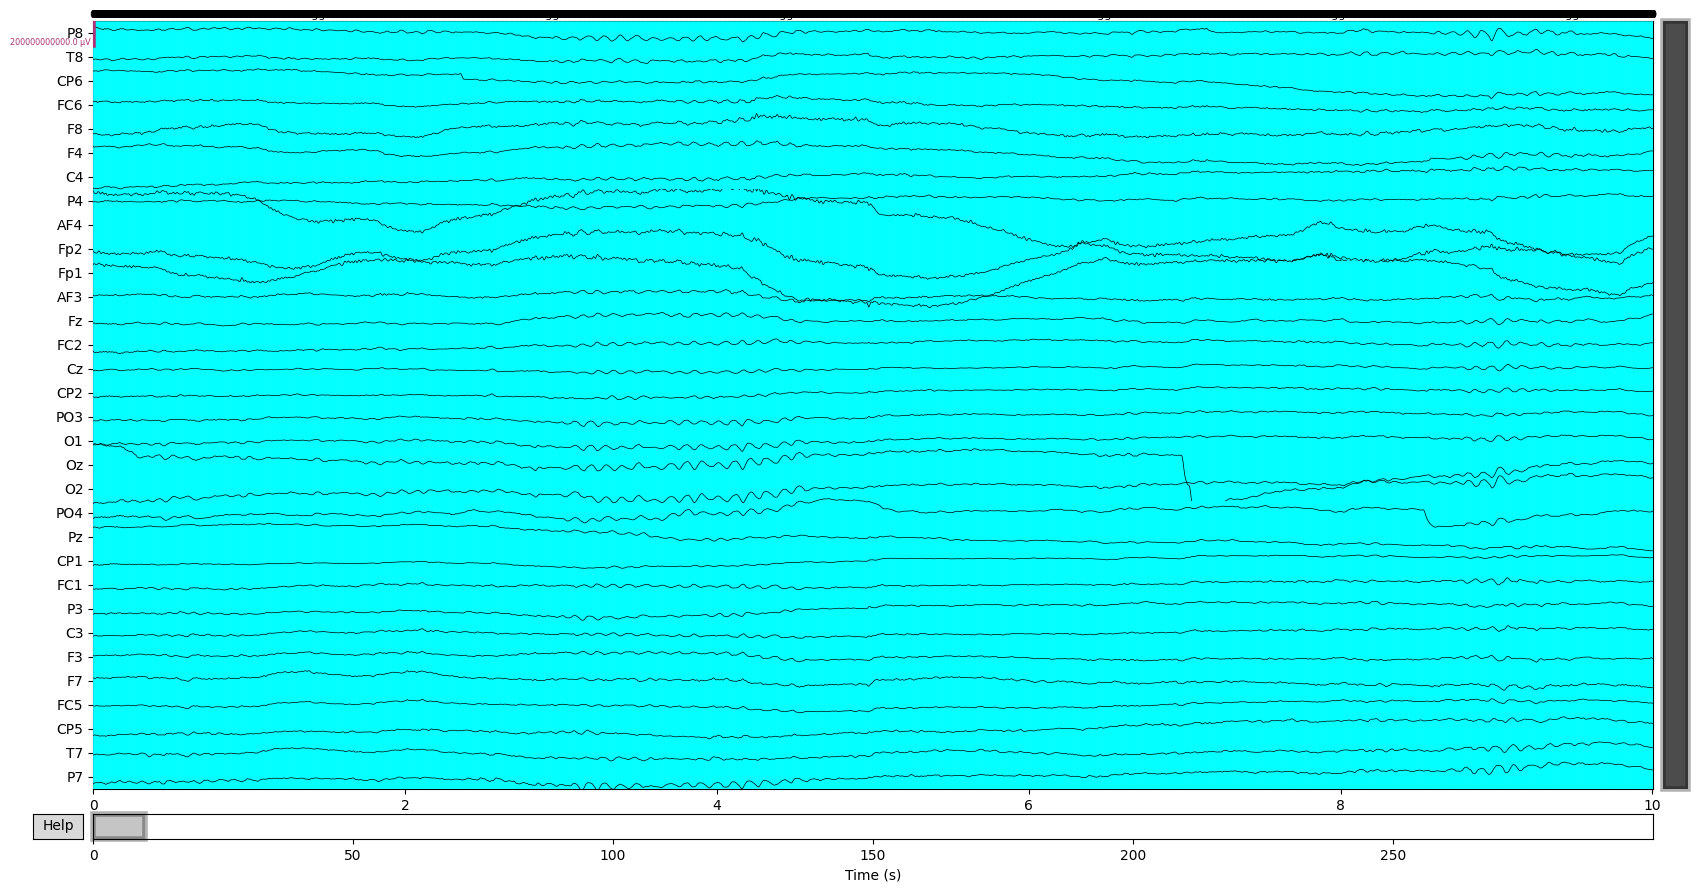

In [290]:
# Adding trigger channel

print(file_path)
trigger_col = df.values[:, -2]

# Create an events array (sample number, previous, trigger value)
event_id = dict(trigger=1) 
events = np.column_stack((np.arange(len(trigger_col)), np.zeros_like(trigger_col), trigger_col)) 

# Plot the EEG data 
raw.plot(n_channels=32, events=events, event_id=event_id, scalings={'eeg': 1e5})


5. Epoching

In [232]:
events_from_annot, event_dict = mne.events_from_annotations(raw)# Get events and event_id from an Annotations object.
print("###########", events_from_annot, event_dict)
event_dict = {'go_stimulus':74, 'nogo_stimulus':75, '76':76}                        # Event dictionaries to extract epochs from continuous data, 
reject_criteria = dict(eeg=100e-6)                              # Absolute Amplitude of each epoch sould be smaller than 100 μV
#                                                                 # tmin is start time before event, tmax is end time after event
#                                                                 # - 100 ms (baseline) of cue's onset to 600 ms
epochs = mne.Epochs(raw, events_from_annot, event_id=event_dict, tmin=-0.1, tmax=1.6,
                    reject=reject_criteria, baseline = (None,0), preload=True, picks=['eeg'])

########### [] {}


ValueError: zero-size array to reduction operation maximum which has no identity

In [237]:
ica = mne.preprocessing.ICA(n_components=50, random_state=97, method='fastica')
ica.fit(epochs)                                      # Data decomposition with 50 components and fastica method.

NameError: name 'epochs' is not defined

In [238]:
%matplotlib inline
# %matplotlib qt
ica.plot_components()  # Plot all decomposed components

RuntimeError: The ICA's measurement info is missing. Please fit the ICA or add the corresponding info object.

In [ ]:
ica.exclude = [11, 26, 29, 30, 33, 34, 35, 36, 38, 44, 48, 49, 0, 6, 17] 
                                        # Put all comonent which you want to remove containg inspected (manual) 
                                        # [11, 26, 29, 30, 33, 34, 35, 36, 38, 44, 48, 49], EOG [0] and ECG [6,17] components
                                        # Selected components are not real
ica.apply(epochs)                       # Channels can be reconstructed using the ICA object’s apply()